# Ungraded Lab: Multi-class Classifier

In this lab, you will look at how to build a model to distinguish between more than two classes. The code will be similar to the ones you've been using before with a few key changes in the model and in the training parameters. Let's dive in!

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

## Download and Inspect the Dataset

You will be using the [Rock-Paper-Scissors dataset](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors), a gallery of hands images in Rock, Paper, and Scissors poses.

As usual, you will assign the directory names into variables and look at the filenames as a sanity check.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile, os

def unzip_files(zip_file='', extract_dir=''):
    if os.path.exists(extract_dir) and os.path.isdir(extract_dir):
        print(f"The folder '{extract_dir}' already exists and is a directory.")
    else:
        print(f"The folder '{extract_dir}' does not exist or is not a directory.")
        print("Unzipping files...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print("Files unzipped successfully.")

# Especificar la ruta del archivo ZIP y la carpeta de extracción
zip_files = 'Files.zip'  # Nombre del archivo ZIP
extract_folder = 'Files/'   # Nombre de la carpeta de extracción

file_path = '/content/drive/MyDrive/Tensorflow/DeepLearning.AI/C2/W4/Ungraded'
os.chdir(file_path)
print(f"The current path is: {file_path}")

# Llamar a la función para descomprimir los archivos
unzip_files(zip_files, extract_folder)

The current path is: /content/drive/MyDrive/Tensorflow/DeepLearning.AI/C2/W4/Ungraded
The folder 'Files/' already exists and is a directory.


In [ ]:
BASE_DIR = 'Files/Files/rps/'

rock_dir = os.path.join(BASE_DIR, 'rock')
paper_dir = os.path.join(BASE_DIR, 'paper')
scissors_dir = os.path.join(BASE_DIR, 'scissors')

print(f'Total training rock images: {len(os.listdir(rock_dir))}')
print(f'Total training paper images: {len(os.listdir(paper_dir))}')
print(f'Total training scissors images: {len(os.listdir(scissors_dir))}')

print('\n')
print(f"Five files in the rock subdir: {os.listdir(rock_dir)[:5]}")
print(f"Five files in the paper subdir: {os.listdir(paper_dir)[:5]}")
print(f"Five files in the scissors subdir: {os.listdir(scissors_dir)[:5]}")

Total training rock images: 840
Total training paper images: 841
Total training scissors images: 840


Five files in the rock subdir: ['rock05ck01-058.png', 'rock06ck02-092.png', 'rock04-076.png', 'rock02-078.png', 'rock01-079.png']
Five files in the paper subdir: ['paper02-024.png', 'paper06-101.png', 'paper01-061.png', 'paper02-105.png', 'paper06-020.png']
Five files in the scissors subdir: ['scissors02-050.png', 'testscissors01-042.png', 'testscissors02-005.png', 'scissors03-013.png', 'scissors01-015.png']


You can also inspect some of the images to see the variety in your model inputs.

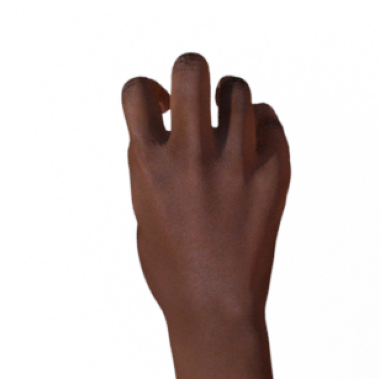

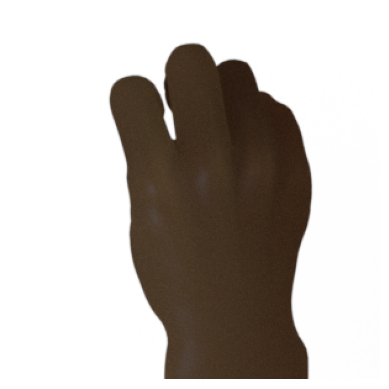

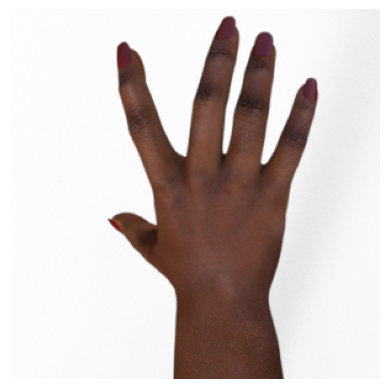

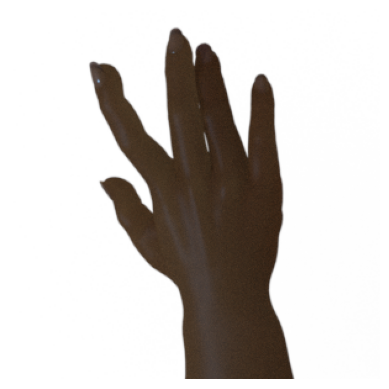

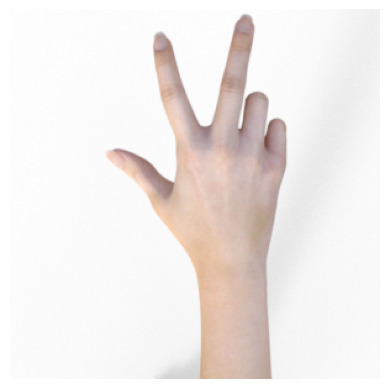

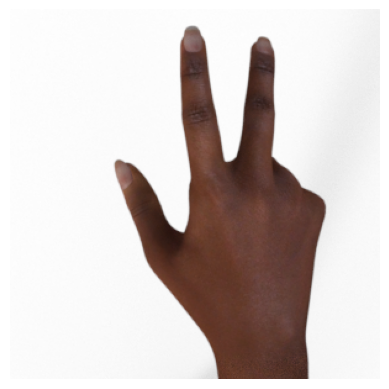

In [ ]:
import random, matplotlib.pyplot as plt, matplotlib.image as mpimg

next_rock = [os.path.join(rock_dir, fname)
             for fname in random.sample(os.listdir(rock_dir), k=2)]
next_paper = [os.path.join(paper_dir, fname)
              for fname in random.sample(os.listdir(paper_dir), k=2)]
next_scissors = [os.path.join(scissors_dir, fname)
                 for fname in random.sample(os.listdir(scissors_dir), k=2)]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

## Build the model

You will then build your CNN. You will use 4 convolution layers with 64-64-128-128 filters then append a `Dropout` layer to avoid overfitting and some `Dense` layers for the classification. The output layer would be a 3-neuron `Dense` layer activated by [Softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax). You've seen this in Course 1 when you were training with Fashion MNIST. It scales your output to a set of probabilities that add up to 1. The order of this 3-neuron output would be paper-rock-scissors (e.g. a `[0.8 0.2 0.0]` output means the model is predicting 80% probability for paper and 20% probability for rock.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import binary_crossentropy

class RockPaperScissorsClassifier:
    def __init__(self):
        self.model = self.cnn_model()

    def cnn_model(self, cnn_filters=[64, 64, 128, 128]):
        '''Creates a CNN with n convolutional layers'''
        cnn_model = Sequential([
            Input(shape=(150, 150, 3)),
            # Rescale the image. Note the input shape is the desired size of the image: 150x150 with 3 bytes for color
            Rescaling(1./255.0),
        ])
        for f in cnn_filters:
            # N convolutional Layer
            cnn_model.add(Conv2D(filters=f, kernel_size=(3, 3), activation='relu'))
            cnn_model.add(MaxPooling2D(2, 2))
        # Flatten the results to feed into a DNN
        cnn_model.add(Flatten())
        tf.keras.layers.Dropout(0.5),
        # 512 neuron hidden layer
        cnn_model.add(Dense(units=512, activation='relu'))
        cnn_model.add(Dense(units=3, activation='softmax'))
        return cnn_model

    def compile_model(self, optimizer=RMSprop, learning_rate=0.001, loss=binary_crossentropy, metrics=['accuracy']):
        self.model.compile(optimizer=optimizer(learning_rate=learning_rate), loss=loss, metrics=metrics)

    def summary(self):
        self.model.summary()

    def fit(self, train_dataset, epochs=15, validation_dataset=None, verbose=None):
        return self.model.fit(x=train_dataset, epochs=epochs, validation_data=validation_dataset, verbose=verbose)

## Preprocess the Image Data

You will prepare the training and validation datasets as before. The label mode will be `categorical` because you will predict more than two classes.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

TRAINING_DIR = "Files/Files/rps/"
VALIDATION_DIR = "Files/Files/rps-test-set"
BATCH_SIZE = 32
IMAGE_SIZE = (150, 150)
LABEL_MODE = 'categorical'
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

def create_dataset(directory, image_size, batch_size=None, label_mode=None, optimizer_dataset=False, shuffle=False):
  dataset =  image_dataset_from_directory(directory=directory, image_size=image_size, batch_size=batch_size, label_mode=label_mode)
  if optimizer_dataset:
    # Optimize the datasets for training
    dataset = dataset.cache() # Almacena en caché primero
    if shuffle:
      dataset.shuffle(SHUFFLE_BUFFER_SIZE) # Baraja si se especifica
    dataset.prefetch(PREFETCH_BUFFER_SIZE) # Realiza la operación de prefijado
  return dataset

# Optimize the datasets for training
train_dataset_final = create_dataset(TRAINING_DIR, IMAGE_SIZE, BATCH_SIZE, LABEL_MODE, True, True)
validation_dataset_final = create_dataset(VALIDATION_DIR, IMAGE_SIZE, BATCH_SIZE, LABEL_MODE, True, False)

Found 2521 files belonging to 3 classes.
Found 372 files belonging to 3 classes.


## Prepare the Model for Training

You will use data augmentation to generate other poses that the model needs to learn.

In [ ]:
# Create an instance of RockPaperScissorsClassifier class.
classifier = RockPaperScissorsClassifier()

# Create a model with data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomZoom(0.2)
    ])

# Show the model without and with augmentation summary
classifier.summary()
data_augmentation.summary()

# Attach the data augmentation model to the base model
model_with_aug = tf.keras.models.Sequential([
    data_augmentation,
    classifier.model
])

model_with_aug.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,473,475 (13.25 MB)

 Trainable params: 3,473,475 (13.25 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 150, 150, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 150, 150, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 3)                   │       3,473,475 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,473,475 (13.25 MB)

 Trainable params: 3,473,475 (13.25 MB)

 Non-trainable params: 0 (0.00 B)

You will compile the model using a [`categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) loss function to quantify the error across all 3 classes.

In [ ]:
# Set the training parameters
model_with_aug.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Train the model and evaluate the results

You will train for 25 epochs and evaludate the results afterwards. Observe how both the training and validation accuracy are trending upwards. This is a good indication that the model is not overfitting to the training set.


In [ ]:
# Train the model
history = model_with_aug.fit(
    train_dataset_final,
    epochs=25,
    validation_data = validation_dataset_final,
    verbose = 1
)

Epoch 1/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 516s 6s/step - accuracy: 0.3362 - loss: 1.2469 - val_accuracy: 0.3333 - val_loss: 1.1056
Epoch 2/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.3975 - loss: 1.1086 - val_accuracy: 0.6694 - val_loss: 0.9013
Epoch 3/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5051 - loss: 0.9949 - val_accuracy: 0.5457 - val_loss: 0.6589
Epoch 4/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6243 - loss: 0.8358 - val_accuracy: 0.8898 - val_loss: 0.4326
Epoch 5/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6961 - loss: 0.6754 - val_accuracy: 0.9624 - val_loss: 0.2167
Epoch 6/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7923 - loss: 0.5224 - val_accuracy: 0.8387 - val_loss: 0.3348
Epoch 7/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8322 - loss: 0.4132 - val_accuracy: 0.9919 - val_loss: 0.3179
Epoch 8/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8733 - loss: 0.3251 - val_accuracy: 0.8038 - v

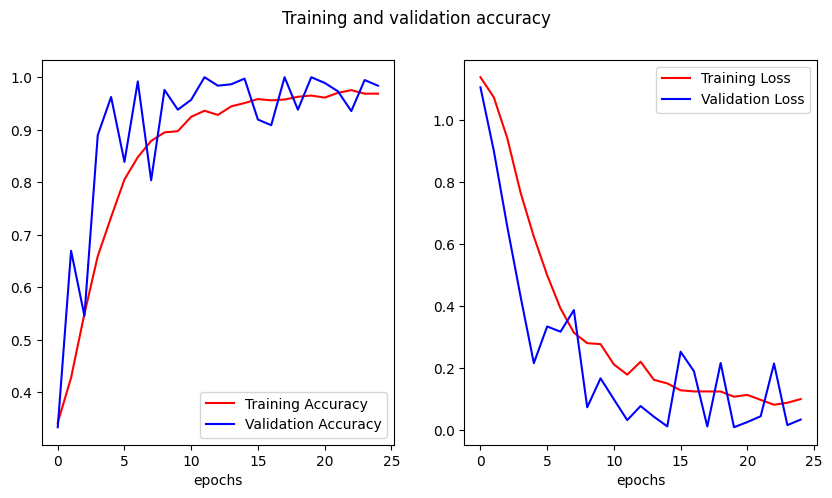

In [ ]:
import matplotlib.pyplot as plt

def plot_training_validation_accuracy_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('Training and validation accuracy')

    for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
        ax[i].plot(epochs, data[0], 'r', label="Training " + label)
        ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
        ax[i].legend()
        ax[i].set_xlabel('epochs')

    plt.show()

plot_training_validation_accuracy_loss(history)

## Model Prediction

You can feed in a picture and have the model classify it as rock, paper, or scissors. You can upload your own images or use the ones available [here](https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps-validation.zip).

In [ ]:
import numpy as np
from ipywidgets import widgets
from io import BytesIO

# Create the widget and take care of the display
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    prediction = model_with_aug.predict(image, verbose=0)[0]

    with out:

        print(f'\nmodel output: {prediction*100}') # express the prediction in percentage.

        prediction_index = np.argmax(prediction)

        classes = ["paper", "rock", "scissors"]

        predicted_class = classes[prediction_index]

        print(f'{filename} is {predicted_class}')


def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""
    for filename, file_info in change['new'].items():  # Iterate over uploaded files
        file_jpgdata = BytesIO(file_info['content'])
        file_predict(filename, file_jpgdata, out)


uploader.observe(on_upload_change, names='value')

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()

## Wrap Up

That concludes this short exercise on the multi-class classifiers. You saw that with just a few changes, you were able to convert your binary classifiers to predict more classes. You used the same techniques for data and model preparation and were able to get relatively good results in just 25 epochs. For practice, you can search for other datasets (e.g. [here](https://archive.ics.uci.edu/datasets)) with more classes and revise the model to accomodate it. Try to experiment with different layers and data augmentation techniques to improve your metrics.